In [1]:
# импорт используемых библиотек

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')


# устанавливаемый единый размер шрифта
matplotlib.rcParams.update({'font.size': 14})

In [2]:
# функция для визуальной валидации результатов предсказания

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [3]:
TRAIN_DATASET_PATH = 'C:/ARTEM/GeekBrains/Python4DS/RealEstatePricePredictionMoscow/train.csv'
TEST_DATASET_PATH = 'C:/ARTEM/GeekBrains/Python4DS/RealEstatePricePredictionMoscow/test.csv'

In [4]:
# загружаем обучающую выборку, проверяем данные
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [5]:
# смотрим типы данных, цель уменьшить размер датасета
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [6]:
# загружаем проверочную выборку, проверяем данные

test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [7]:
# размеры датасетов

print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [8]:
# проверяем размерности датасетов - обучающий нимеет на столбец больше проверочного
train_df.shape[1] - 1 == test_df.shape[1]

True

In [9]:
# приведение типов к строкам, чтобы модель не применяла <> для этих данных
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

# уменьшаем размерности этажей,этажностей, возраста
train_df['Floor'] = train_df['Floor'].astype(np.int16)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(np.int16)
train_df['HouseYear'] = train_df['HouseYear'].astype(np.int16)


# проверяем преобразование
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int16
HouseFloor         int16
HouseYear          int16
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
### Исследуем данные

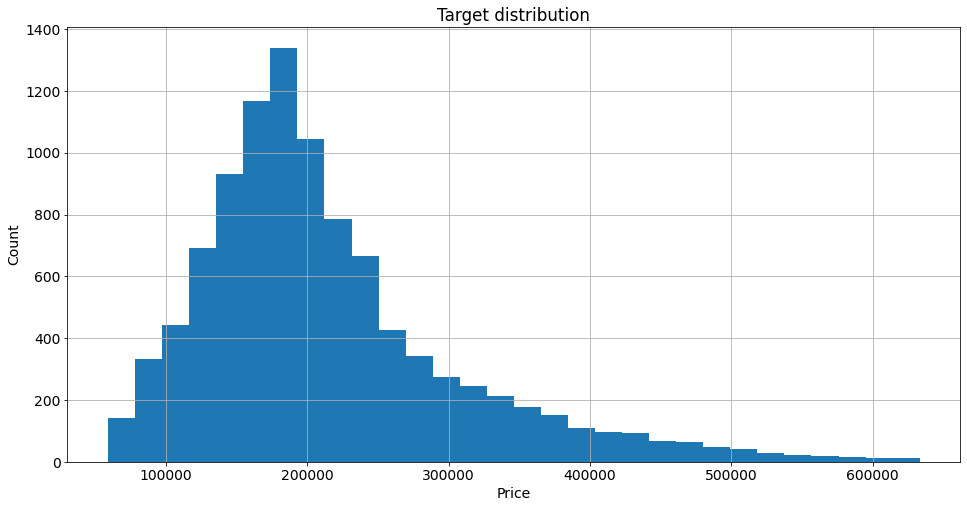

In [11]:
# гистограма распределения целевых значений
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [12]:
# смотрим на параметры для данных выборки
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,1984.764700,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,53.112756,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,-2005.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,4968.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [13]:
# количество комнат 
# 0 - допустимое значение для студии
# площадь

In [14]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [19]:
# Обработка выбросов



In [20]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [21]:
# пример, где считаем выбросами количество комнат равное 0 или >=6: создаем столбец Rooms_outlier, 
# где указываем недоверие к числу комнат

#train_df['Rooms_outlier'] = 0
#train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
#train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
#train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [22]:
train_df['Rooms'].value_counts()


2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [23]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [24]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [25]:
# обрабатываем выбросы в площадях кухни
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [26]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

In [27]:
# исследуем этажность зданий

train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117], dtype=int16)

In [28]:
# исследуем этаж

train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int16)

In [29]:
# находим случаи, когда этаж больше этажности здания
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [30]:
# добавляем признак достоверности этажа
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [31]:
# некорректную этажность заменяем медианой
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [32]:
# смотрим на id проблемных записей по этажам
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [33]:
#Добавляем цену квадратного метра AV
train_df['Meter_price'] = 0
train_df.loc[train_df['Square'] > 0, 'Meter_price'] = train_df['Price'] / train_df['Square']
#train_df['Meter_price'].sort_values(ascending=False)
train_df[['Price', 'Square', 'Meter_price']].describe()

,Price,Square,Meter_price
count,10000.000000,10000.000000,10000.000000
mean,214138.857399,56.315775,3988.383777
std,92872.293865,21.058732,3755.437224
min,59174.778028,1.136859,208.293451
25%,153872.633942,41.774881,2918.525328
50%,192269.644879,52.513310,3910.052336
75%,249135.462171,65.900625,4692.375993
max,633233.466570,641.065193,230463.537966


In [34]:
# подстановка для значений этажа
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [35]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

In [36]:
# выводим года постройки
train_df['HouseYear'].sort_values(ascending=False)

8828    4968
6073    2020
5641    2020
2350    2020
9091    2020
        ... 
6250    1914
2066    1912
2795    1912
6794    1910
9163   -2005
Name: HouseYear, Length: 10000, dtype: int16

In [37]:
# если год постройки еще не наступал, то меняем на текущий, можно менять на медиану
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021
# если дом слишком древний, до 1910 - это первый разумный минимум. Заменяем медианой
train_df.loc[train_df['HouseYear'] < 1910, 'HouseYear'] = train_df['HouseYear'].median()
# год можно также предсказывать по этажности, по району и т.д.


In [38]:
# обработка пропусков

In [39]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
HouseFloor_outlier       0
Meter_price              0
dtype: int64

In [40]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


In [41]:
# если нет данных по жилой площади - добавляем признак и пытаемся расчитать
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [42]:
#train_df[['Healthcare_1','Healthcare_2']].head(10)

In [43]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [44]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # AV
        #==========================================================================
        X.loc[X['HouseYear'] < 1910, 'HouseYear_outlier'] = 1 
        X.loc[X['HouseYear'] < 1910, 'HouseYear'] = self.medians['HouseYear']
        #==========================================================================
        X.loc[X['Square'].isna(), 'Square'] = self.medians['Square']    
        #==========================================================================
    
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [45]:
# построение новых признаков

In [46]:
# заменяем A/B на 0/1
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [47]:
# добавляем размер района
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [48]:
# добавляем призак в датасет
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier,Meter_price,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10,2014,0.075424,...,3097,0,0,0,1,305018.871089,0,2651.708272,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,4462.045990,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,3600.596698,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22,1977,0.007122,...,264,0,0,1,1,168106.007630,0,4160.019670,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,5351.088794,0,89


In [49]:
# большие районы
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [50]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [51]:
# медианная стоимость по району
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239


In [52]:
med_price_by_district.shape

(675, 3)

In [53]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier,Meter_price,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10,2014,0.075424,...,0,0,1,305018.871089,0,2651.708272,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,...,1,0,1,177734.553407,0,4462.045990,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,...,3,1,1,282078.720850,0,3600.596698,0,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22,1977,0.007122,...,0,1,1,168106.007630,0,4160.019670,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16,1972,0.282798,...,0,6,1,343995.102962,0,5351.088794,0,89,0,201584.441255


In [54]:
# категоризация
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [55]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [56]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64, right]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [57]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,HouseFloor_outlier,Meter_price,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10,2014,0.075424,...,1,305018.871089,0,2651.708272,1,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,...,1,177734.553407,0,4462.045990,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,...,1,282078.720850,0,3600.596698,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22,1977,0.007122,...,1,168106.007630,0,4160.019670,1,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16,1972,0.282798,...,1,343995.102962,0,5351.088794,0,89,0,201584.441255,3,5


In [58]:
#!!! медианная цена по году и этажу
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,374737.658654
1,1,2,322905.044793
2,1,3,429825.896082
3,1,4,274992.472366
4,2,1,467230.539057


In [59]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,HouseFloor_outlier,Meter_price,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10,2014,0.075424,...,305018.871089,0,2651.708272,1,851,1,213530.788443,6,2,161974.797753
1,3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,...,177734.553407,0,4462.045990,0,78,0,146032.829834,3,3,192538.872015
2,8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,...,282078.720850,0,3600.596698,0,652,1,244005.272380,4,1,204670.096676
3,2352,1,1.0,40.409907,34.409907,3.0,10,22,1977,0.007122,...,168106.007630,0,4160.019670,1,652,1,146735.671740,3,4,183505.979560
4,13866,94,2.0,64.285067,38.562517,9.0,16,16,1972,0.282798,...,343995.102962,0,5351.088794,0,89,0,201584.441255,3,5,173955.556579


In [60]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.meter_price = None      #AV
        self.meter_price_by_district_rooms = None   #AV
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
        if y is not None:
            df['Price'] = y.values
            self.meter_price = df['Price']/df['Square']      #AV    
        
        
        if y is not None:
            df['Price'] = y.values            
            df = self.fill_meter_price(df)
            self.meter_price_by_district_rooms = df.groupby(['DistrictId', 'Rooms'], as_index=False).\
                                            agg({'MeterPrice':'median'}).\
                                            rename(columns={'MeterPrice':'MeterPriceByDistrictRooms'})
            
          
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
          
        # AV
        X['MeterPrice'] = self.meter_price
        X['MeterPrice'].fillna(3910,inplace = True)
        #X.loc[(X['Square'] > 0), 'MeterPrice'] = X['Price'] / X['Square'] 
        
        if self.meter_price_by_district_rooms is not None:
            X = X.merge(self.meter_price_by_district_rooms, on=['DistrictId', 'Rooms'], how='left')
            X['MeterPriceByDistrictRooms'].fillna(self.med_price_by_floor_year_median, inplace=True)        
        
                
        return X    
     
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    def fill_meter_price(self, X):    #AV
        X['MeterPrice'] = self.meter_price
        X['MeterPrice'].fillna(3910,inplace = True)
        X.loc[(X['Square'] > 0), 'MeterPrice'] = X['Price'] / X['Square']
        return X
    

In [61]:
# отбор призаков
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'HouseFloor_outlier',
 'Meter_price',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [62]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear', 'MeterPrice',
                     'MeterPriceByDistrictRooms']

target_name = 'Price'

In [63]:
# разбиение на train и test

In [64]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [66]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [67]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 31), (3300, 31), (5000, 31))

In [68]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [69]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [70]:
# построение модели

In [71]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=21)

Train R2:	0.967
Test R2:	0.722


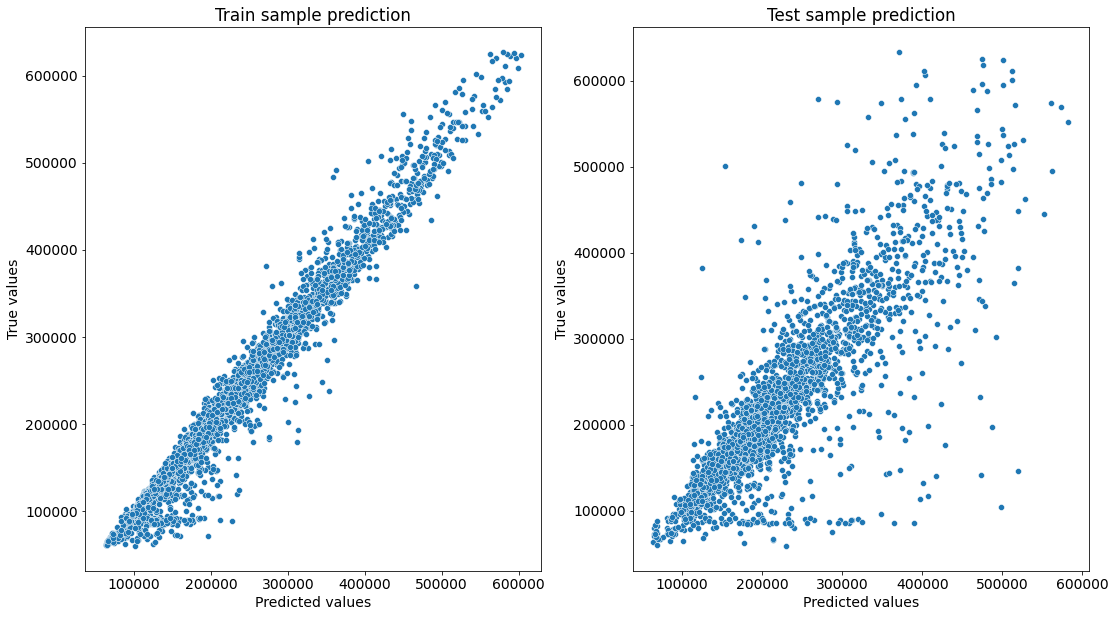

In [72]:
 # оценка модели
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [73]:
# кросс валидация

In [74]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.78324412, 0.73308622, 0.76224678])

In [75]:
cv_score.mean()

0.7595257056684376

In [76]:
# веса признаков
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
23,MedPriceByDistrict,6.377276e-01
1,Square,1.169206e-01
26,MeterPriceByDistrictRooms,5.302766e-02
2,LifeSquare,2.742734e-02
6,HouseYear,1.880421e-02
24,MedPriceByFloorYear,1.836782e-02
5,HouseFloor,1.637686e-02
25,MeterPrice,1.623973e-02
4,Floor,1.337890e-02
3,KitchenSquare,1.172162e-02


In [77]:
# выгрузка результатов
test_df.shape

(5000, 27)

In [78]:
submit = pd.read_csv('C:/ARTEM/GeekBrains/Python4DS/RealEstatePricePredictionMoscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [79]:
predictions = rf_model.predict(test_df)
predictions

array([164129.41193348, 117169.5995882 , 139193.78182605, ...,
       148103.70058817, 189761.30723796, 229074.87215388])

In [80]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,164129.411933
1,5925,117169.599588
2,960,139193.781826
3,3848,169578.024348
4,746,171922.946686


In [81]:
submit.to_csv('C:/ARTEM/GeekBrains/Python4DS/RealEstatePricePredictionMoscow/rf_submit.csv', index=False)